<a href="https://colab.research.google.com/github/lokalov/lokalov_ML/blob/dataset/courses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Добавление библиотек

In [265]:
!pip install --upgrade matplotlib > None # need refresh enviroment after installation

In [269]:
#pip install numpy

In [270]:
#pip install pandas

In [271]:
import pandas as pd

In [278]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.cbook import boxplot_stats
from sklearn.preprocessing import scale


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

%matplotlib inline

## Подготовка данных

In [227]:
path = 'https://github.com/lokalov/lokalov_ML/raw/main/datasetVAL.xlsx'
data = pd.read_excel(path, index_col='Unnamed: 0')

In [228]:
data.head()

,N,VOZR,GOD_POST,VREM_OB,COD_COURS,UROVEN,NAPR,UZNAL,VR_PUT,PROFROD,TEACHER,STAG
1,6561,13,2016,1,6,3,2,знакомые,32,инженер,150,0
2,6587,14,2016,8,13,3,4,интернет,15,инженер,140,1
3,6971,14,2016,8,13,3,4,интернет,5,заведующий,140,1
4,6984,16,2016,8,16,3,7,знакомые,33,преподаватель,7,13
5,7045,14,2016,8,11,2,5,знакомые,17,менеджер,144,0



*   N - идентификационный номер учащегося
*   VOZR - полных лет учащемуся
*   GOD_POST - год поступления на курс
*   VREM_OB - продолжительность обучения (в месяцах)Новый пункт
*   COD_COURS - код курса - коррелирует с относительной сложностью курса
*   UROVEN - степень специализации курса (1-2-3)
*   NAPR - код предметной области (напр. графика, web-дизайн и т.д)
*   UZNAL - источник информации о курсах
*   VR_PUT - примерное время на дорогу до курсов (мин)
*   PROFROD - профессия родителя (заказчика)
*   TEACHER - код преподавателя
*   STAG - стаж преподавателя (в годах на год поступления учащегося)








In [229]:
data.shape

(3759, 12)

In [230]:
data.dtypes

N             int64
VOZR          int64
GOD_POST      int64
VREM_OB       int64
COD_COURS     int64
UROVEN        int64
NAPR          int64
UZNAL        object
VR_PUT        int64
PROFROD      object
TEACHER       int64
STAG          int64
dtype: object

## Выбор целевого показателя

Целевой показатель - принадлежность к классам обучающихся более одного года.  Предсказываем, к какому классу обучающихся будет принадлежать клиент, поступивший на курс.
0-проучится год
1-проучится 2 года
2 -проучится 3 года
и т.д.


Агрегирование данных

Данные группируются по учащимся с целью получения датафрейма, позволяющего проанализировать целевой показатель - предсказать количество клиентов, корорые запишутся на следующий год.
 Интервал (INT) между годом записи на последний курс и годом записи на первый определяет класс клиента.
(VR_OB, sum) - учитывает, возможность параллельного прохождения учащимся нескольких курсов. Своего рода "интенсивность обучения".

Можно предположить, что наиболее существенными параметрами, влияющими на целевой показатель будут:


1.   Возраст учащегося VOZR, first (чем младше учащийся, тем меньше в среднем от подготовлен, меньше специализирован)
2.   Уровень UROVEN и конкретный курс, на который пришел учащийся, его соответствие возрасту
3.   Преподаватель и опыт его работы (STAG). Важно учитывать как первого учителя (на первом курсае), который должен заитнересовать учащегося, так и последнего, который в принципе может быть причиной того, что учащийся покидает курсы
4. (VR_OB, sum) Время обучения (в месяцах).



In [231]:
agg_func_selection = {'VR_PUT':['first'],'GOD_POST':['first','last'],'VOZR':['first'],'TEACHER': ['first', 'last'],'STAG': ['first', 'last'],'VREM_OB' : ['sum'], 'COD_COURS': ['first','last'], 'UROVEN': ['first','last']}

In [232]:
df=data.groupby(['N'], as_index= True).agg(agg_func_selection)

Убираем поступивших и закончивших в последнем году

In [248]:
GOD_MAX=df['GOD_POST','last'].max()

In [234]:
 dfs=df.loc[(df['GOD_POST','first'] < GOD_MAX)&(df['GOD_POST','last']  < GOD_MAX)]


Приводим год начала обучения к 0

In [235]:
INT = df.loc[:,('GOD_POST','last')]-df.loc[:,('GOD_POST','first')]

In [236]:
df['INT']=INT


Сбрасываем столбцы с конкретными годами поступлений на курсы

In [239]:
dfs=df.drop([('GOD_POST','last'),('GOD_POST','first')],axis=1)

dfs - датасет для разведывательного анализа

In [240]:
dfs.shape

(2036, 12)

## EDA (разведывательный анализ данных)

In [241]:
dfs.head()

VR_PUT  VOZR TEACHER       STAG      VREM_OB COD_COURS      UROVEN       \
      first first   first last first last     sum     first last  first last   
N                                                                              
6561     32    13     150  150     0    0       1         6    6      3    3   
6587     15    14     140  140     1    1       8        13   13      3    3   
6971      5    14     140  140     1    1       8        13   13      3    3   
6984     33    16       7    7    13   13       8        16   16      3    3   
7045     17    14     144  144     0    1      16        11   19      2    3   

     INT  
          
N         
6561   0  
6587   0  
6971   0  
6984   0  
7045   1

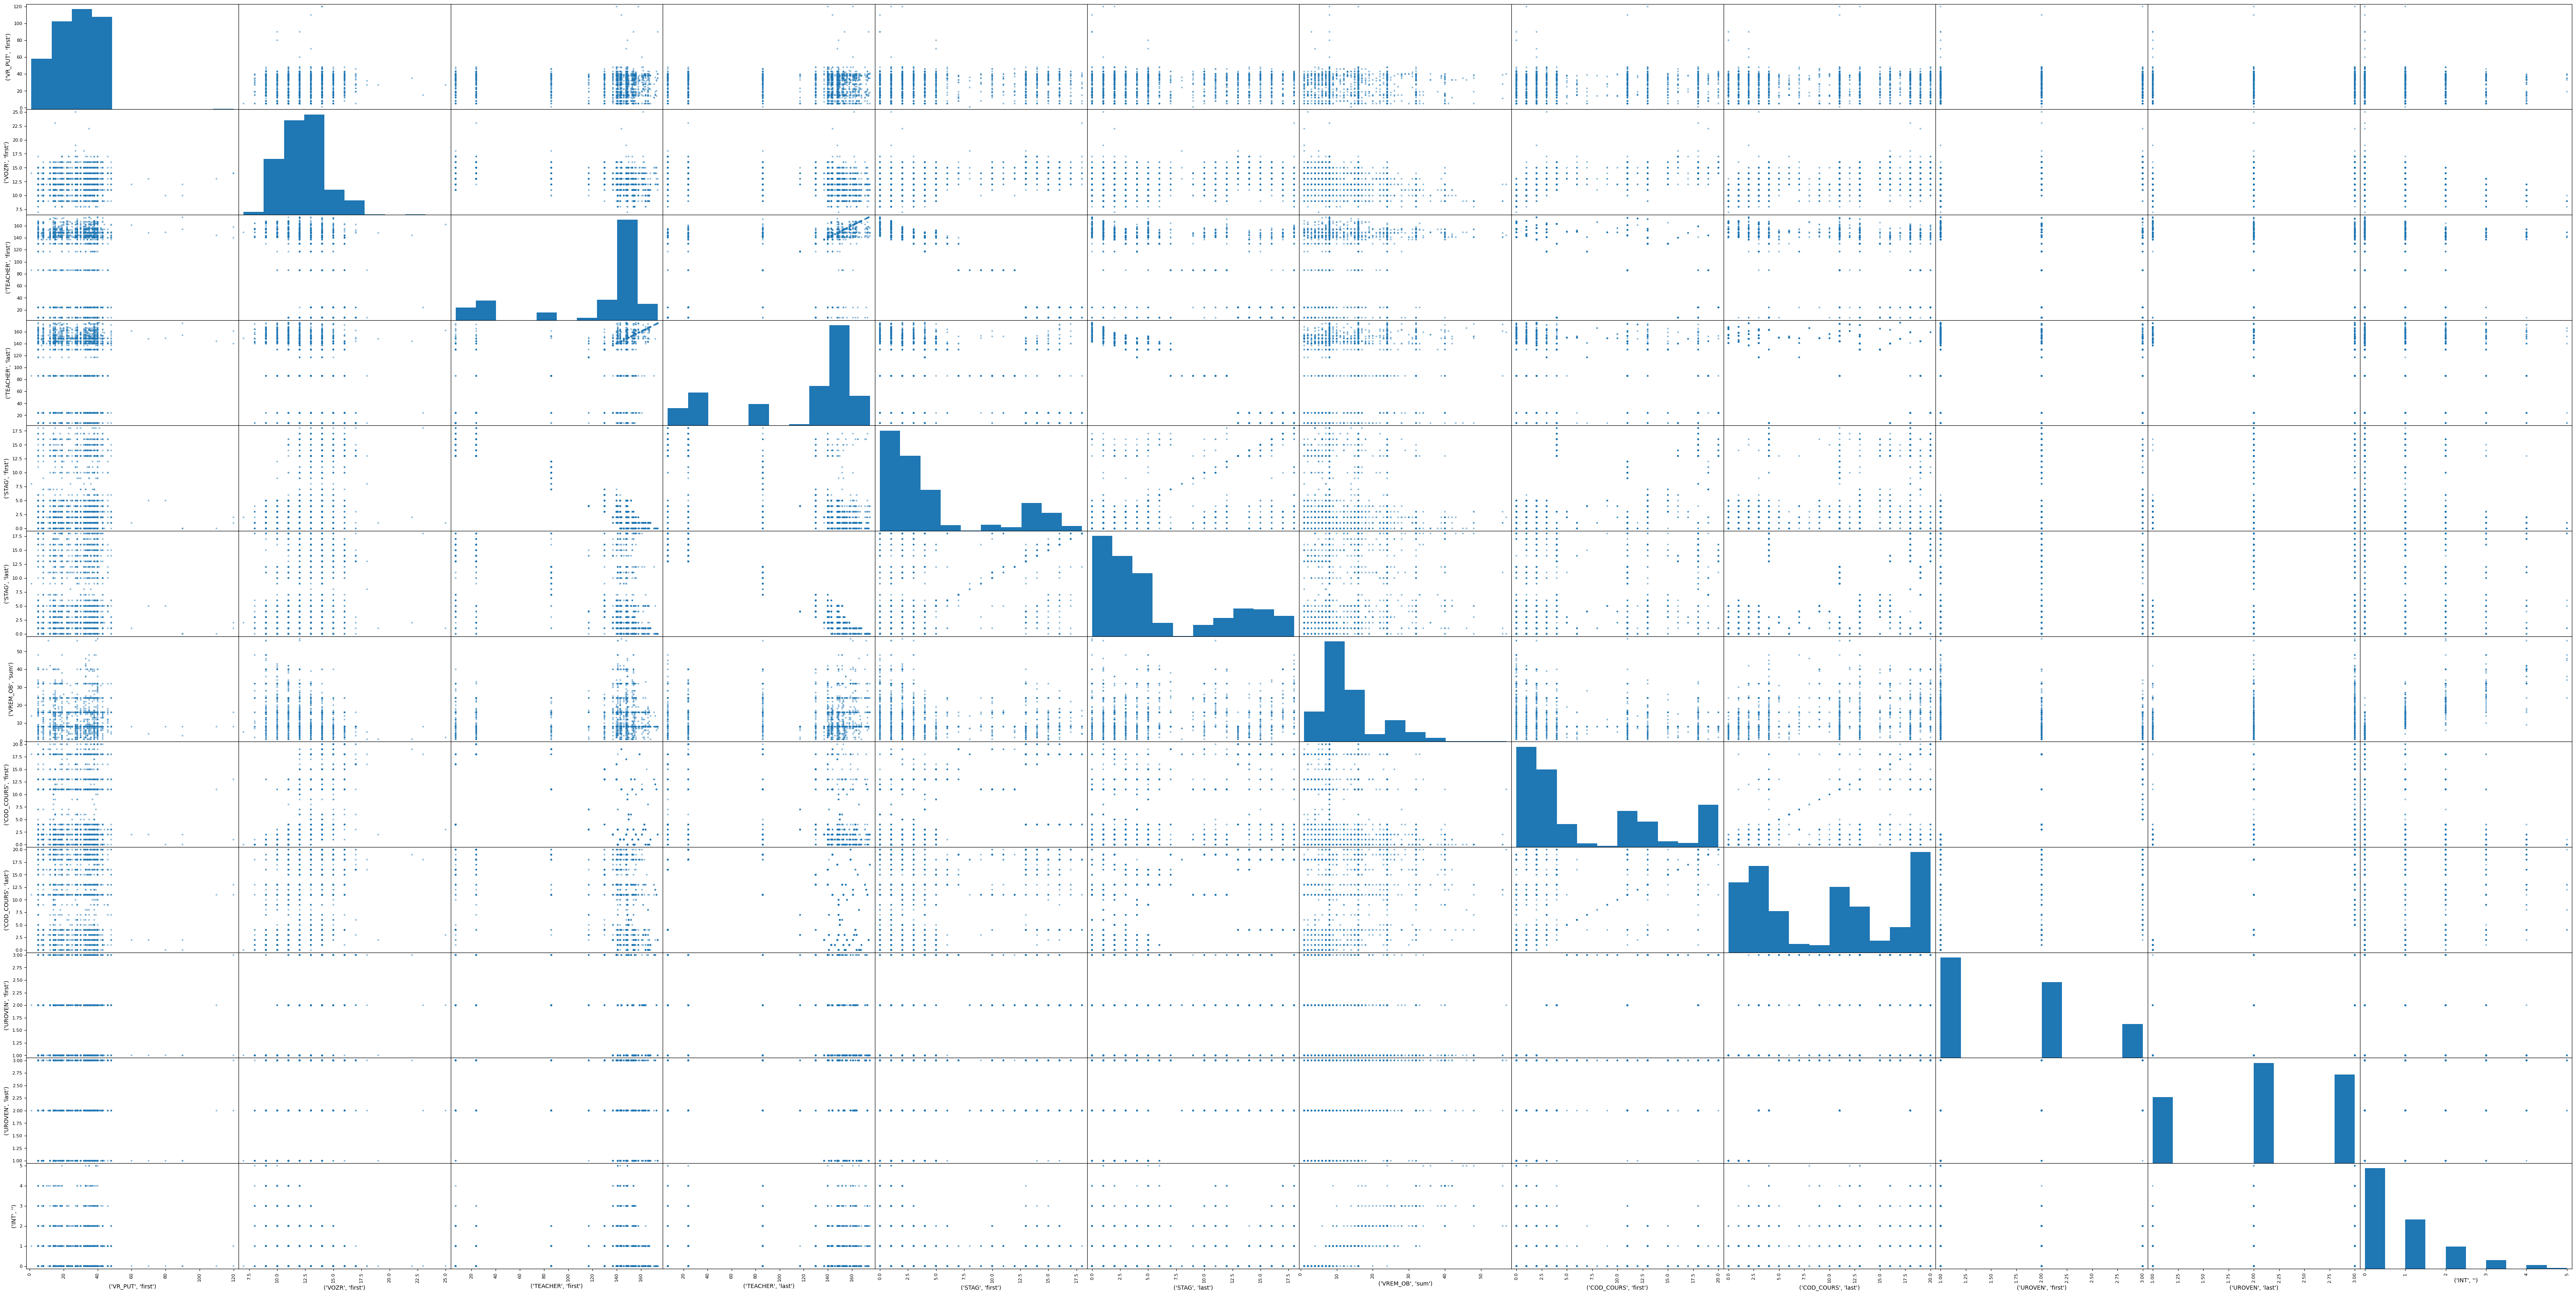

In [242]:
pd.plotting.scatter_matrix(dfs,figsize=(80,40));

In [243]:
dfs.dtypes

VR_PUT     first    int64
VOZR       first    int64
TEACHER    first    int64
           last     int64
STAG       first    int64
           last     int64
VREM_OB    sum      int64
COD_COURS  first    int64
           last     int64
UROVEN     first    int64
           last     int64
INT                 int64
dtype: object

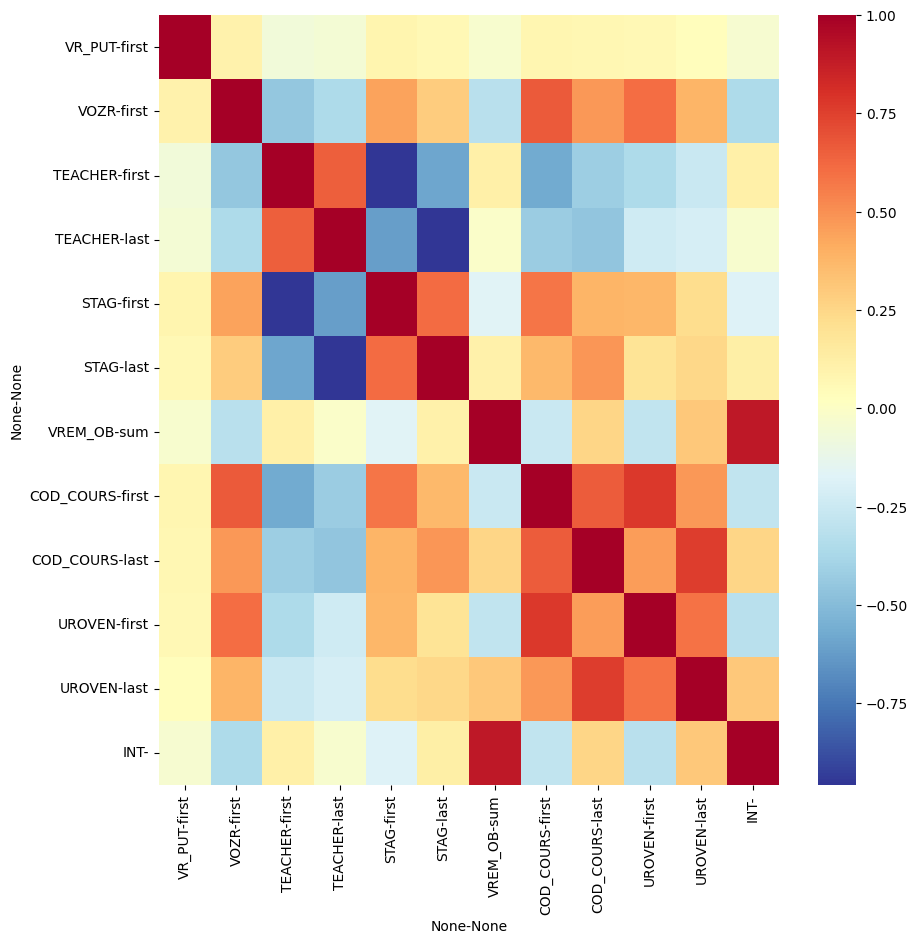

In [244]:
plt.figure(figsize=(10,10))
sns.heatmap(dfs.corr(), cmap="RdYlBu_r");

Тепловая карта показала ряд неочевидных зависимостей. Их можно интерпретировать в контексте конкретной ситуации, которую надо исправлять.
Например, слабая отрицательная корреляция возраста поступления, уровня специализации первых курсов с общим временем обучения.
Положительная корреляция UROVEN-last COD_COURS-last говорит об том, что учащихся чаще задерживаются именно на специализированных курсах, со вводных чаще уходят.



In [247]:
dfs.corr().round(2)

VR_PUT  VOZR TEACHER        STAG       VREM_OB COD_COURS  \
                 first first   first  last first  last     sum     first   
VR_PUT    first   1.00  0.10   -0.07 -0.05  0.09  0.06   -0.03      0.08   
VOZR      first   0.10  1.00   -0.45 -0.36  0.44  0.29   -0.32      0.67   
TEACHER   first  -0.07 -0.45    1.00  0.65 -0.96 -0.58    0.12     -0.57   
          last   -0.05 -0.36    0.65  1.00 -0.62 -0.96   -0.02     -0.43   
STAG      first   0.09  0.44   -0.96 -0.62  1.00  0.61   -0.17      0.59   
          last    0.06  0.29   -0.58 -0.96  0.61  1.00    0.11      0.37   
VREM_OB   sum    -0.03 -0.32    0.12 -0.02 -0.17  0.11    1.00     -0.26   
COD_COURS first   0.08  0.67   -0.57 -0.43  0.59  0.37   -0.26      1.00   
          last    0.07  0.47   -0.41 -0.46  0.39  0.48    0.25      0.66   
UROVEN    first   0.06  0.60   -0.36 -0.24  0.38  0.19   -0.29      0.77   
          last    0.03  0.39   -0.26 -0.21  0.23  0.25    0.31      0.48   
INT              -0.03 -0.35    0.12 -0.03 -0.18  0.13    0.90     -0.29   

                      UROVEN         INT  
                 last  first  last        
VR_PUT    first  0.07   0.06  0.03 -0.03  
VOZR      first  0.47   0.60  0.39 -0.35  
TEACHER   first -0.41  -0.36 -0.26  0.12  
          last  -0.46  -0.24 -0.21 -0.03  
STAG      first  0.39   0.38  0.23 -0.18  
          last   0.48   0.19  0.25  0.13  
VREM_OB   sum    0.25  -0.29  0.31  0.90  
COD_COURS first  0.66   0.77  0.48 -0.29  
          last   1.00   0.46  0.76  0.25  
UROVEN    first  0.46   1.00  0.59 -0.32  
          last   0.76   0.59  1.00  0.31  
INT              0.25  -0.32  0.31  1.00

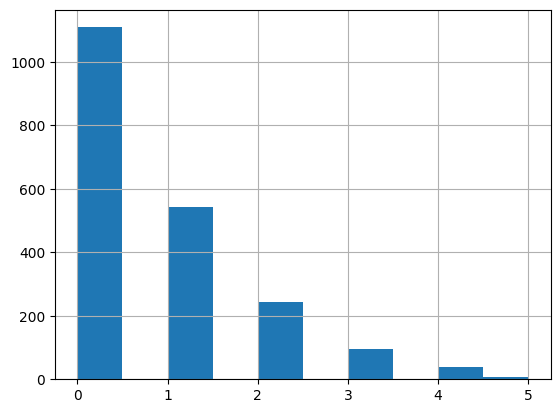

In [246]:
dfs['INT'].hist();



Гистограмма целевого показателя (основные классы учащихся (по количеству лет обучения - целые числа)).


# Выбор критерия качества

In [313]:
y=dfs['VREM_OB','sum']
X_train, X_test, y_train, y_test = train_test_split(dfs, y, random_state=2300, test_size=0.25)

In [314]:
X_train.head()

VR_PUT  VOZR TEACHER       STAG      VREM_OB COD_COURS      UROVEN       \
       first first   first last first last     sum     first last  first last   
N                                                                               
11713     34    14      24   24    16   16       8        20   20      3    3   
9035      32    12     148  148     0    0       8         2    2      1    1   
10971     34    12     143   86     2   11      24         1   11      1    2   
10682     90    10     154  154     0    0       3         0    0      1    1   
10249     32    10     141  130     2    7      16         0   13      1    3   

      INT  
           
N          
11713   0  
9035    0  
10971   2  
10682   0  
10249   3

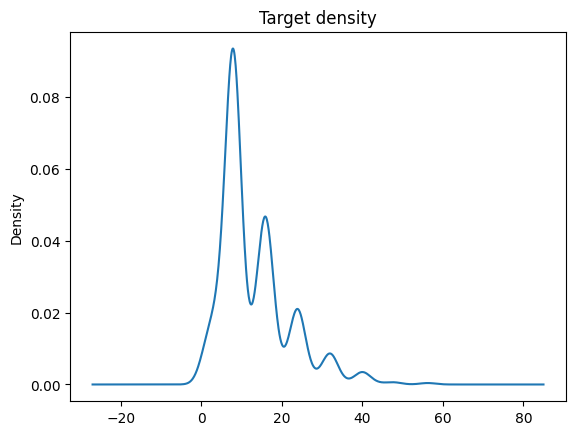

In [315]:
y.plot(kind='kde', title='Target density');

In [305]:
dummy = DummyRegressor(strategy='median')
dummy.fit(X_train, y_train)
y_preds_dummy = dummy.predict(X_test)

В качестве критерия качества - точность предсказания,